In [1]:
import torch
import numpy as np
import pandas as pd
import transformers
import os
from torch.utils.checkpoint import checkpoint
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import nn
from tqdm import tqdm
from datasets import load_dataset
from torchvision import transforms, models
from transformers import BertTokenizer
import matplotlib.pyplot as plt

## Dataset preparation

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
device

device(type='cuda')

In [4]:
dataset_dir = 'data/dataset/'

In [5]:
ans_space_path = f'{dataset_dir}/answer_space.txt'

with open(ans_space_path, 'r') as f:
    data = f.read()
    classes = data.split('\n')
    n_classes = len(classes)

    classes_to_idx = {
        cls_name: idx for idx, cls_name in enumerate(classes)
    }

    idx_to_classes = {
        idx: cls_name for idx, cls_name in enumerate(classes)
    }

In [ ]:
from torch.utils.data import Dataset
import pandas as pd
import torch
from tqdm import tqdm
from transformers import BertTokenizer
from PIL import Image
import os

class VQADataset(Dataset):
    train_answer_ids = set()

    def __init__(self, csv_file, image_folder, transform=None, preprocessed_file=None, train=False):
        self.train = train
        self.image_folder = image_folder
        self.transform = transform

        if preprocessed_file and os.path.exists(preprocessed_file):
            self.data = torch.load(preprocessed_file)
        else:
            self.data = self.preprocess_data(csv_file)
            if preprocessed_file:
                torch.save(self.data, preprocessed_file)

    def get_vocab_size(self):
        return self.tokenizer.vocab_size

    def preprocess_data(self, csv_file):
        df = pd.read_csv(csv_file)
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.tokenizer = tokenizer

        preprocessed_data = []

        for _, row in tqdm(df.iterrows(), total=len(df)):
            image_id = row['image_id']
            question = row['question']
            answer = row['answer']

            encoding = tokenizer(
                question,
                max_length=512,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )

            input_ids = encoding['input_ids'].squeeze(0)
            attention_mask = encoding['attention_mask'].squeeze(0)
            answer_id = classes_to_idx[answer.split(',')[0]]

            if self.train:
                VQADataset.train_answer_ids.add(answer_id)
                preprocessed_data.append({
                    'image_id': image_id,
                    'question': question,
                    'answer': answer,
                    'input_ids': input_ids,
                    'attention_mask': attention_mask,
                    'answer_id': answer_id
                })
            else:
                if answer_id in VQADataset.train_answer_ids:
                    preprocessed_data.append({
                        'image_id': image_id,
                        'question': question,
                        'answer': answer,
                        'input_ids': input_ids,
                        'attention_mask': attention_mask,
                        'answer_id': answer_id
                    })

        return preprocessed_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_point = self.data[idx]
        image_id = data_point['image_id']
        input_ids = data_point['input_ids']
        attention_mask = data_point['attention_mask']
        answer_id = data_point['answer_id']
        question = data_point['question']
        answer = data_point['answer']

        image_path = os.path.join(self.image_folder, f"{image_id}.png")
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, question, answer, input_ids, attention_mask, answer_id

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = VQADataset(dataset_dir + 'data_train.csv',
                           dataset_dir + 'images',
                           transform,
                           train=True)
val_dataset = VQADataset(dataset_dir + 'data_eval.csv',
                         dataset_dir + 'images',
                         transform)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 9974/9974 [00:05<00:00, 1879.98it/s]
/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 2494/2494 [00:01<00:00, 1910.70it/s]


In [8]:
def imshow(image_tensor):
    image_tensor = image_tensor.clone().detach()
    image_tensor = image_tensor.permute(1, 2, 0)
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_tensor = image_tensor.numpy() * std + mean

    image_tensor = np.clip(image_tensor, 0, 1)
    plt.imshow(image_tensor)
    plt.axis('off')
    plt.show()

In [9]:
len(train_dataset), len(val_dataset)

(9974, 2463)

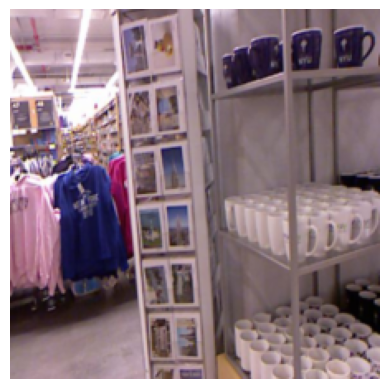

what is the object on the shelves
cup


In [10]:
image, question, answer, input_ids, attention_mask,_ = train_dataset[0]

imshow(image)
print(question, answer, sep='\n')

In [15]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          shuffle=True, num_workers=3, pin_memory=True)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=3, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


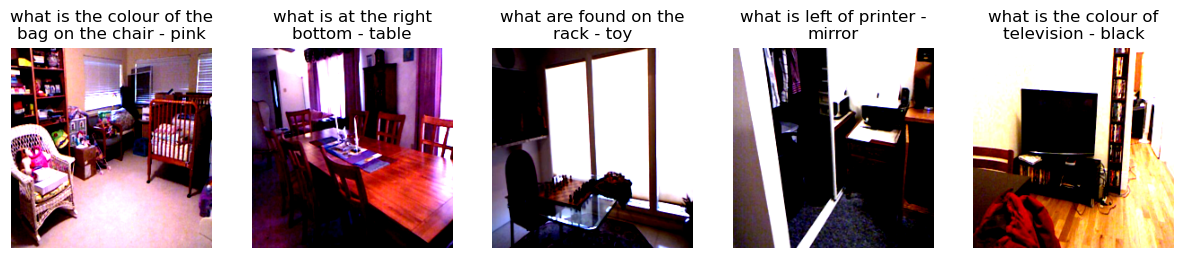

In [16]:
import textwrap

for images, questions, answers, input_ids, attention_mask,_ in val_loader:
    images = images[:5]
    questions = questions[:5]
    answers = answers[:5]
    
    images = images * 0.5 + 0.5
    images_np = images.numpy().transpose(0, 2, 3, 1)

    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for idx in range(5):
        axes[idx].imshow(images_np[idx])
        wrapped_text = "\n".join(textwrap.wrap(questions[idx] + " - " + answers[idx], width=25))
        axes[idx].set_title(wrapped_text)
        axes[idx].axis('off')
    plt.show()
    
    break

## NLP model

### Bert based

In [17]:
import torch
import torch.nn as nn
import torchvision.models as models
from transformers import BertModel, BertTokenizer

In [18]:
class BERTTextEncoder(nn.Module):
    def __init__(self,finetune=True):
        super(BERTTextEncoder, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        for param in self.bert.parameters():
            param.requires_grad = finetune
    
    def forward(self, input_ids, attention_mask):
        outputs = checkpoint(self.bert, input_ids, attention_mask,use_reentrant=False)
        return outputs.last_hidden_state[:, 0, :]

In [19]:
image, question, answer, input_ids, attention_mask,_ = train_dataset[0]
bert_encoder = BERTTextEncoder()

with torch.no_grad():
    embedding = bert_encoder(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))

print("Embedding shape:", embedding.shape)
print("Embedding:\n", embedding)

Embedding shape: torch.Size([1, 768])
Embedding:
 tensor([[-1.9107e-01,  2.3815e-01,  1.9176e-03,  1.7936e-02, -1.1061e-01,
          5.3029e-02,  3.2129e-01,  4.1568e-01, -3.5410e-01, -8.3553e-02,
          5.9893e-02, -1.1319e-01,  1.2816e-01,  4.5366e-01,  6.0528e-02,
          2.6019e-02, -1.3498e-01,  6.1124e-01,  2.9227e-01,  7.9068e-02,
         -1.2588e-02, -1.1963e-01, -2.8246e-01, -4.1931e-01,  5.7790e-02,
          6.9245e-02, -1.0182e-01, -3.7027e-01, -2.1240e-01, -6.7674e-02,
          6.4129e-02, -6.2312e-02, -6.1010e-02, -1.2331e-01, -9.9663e-02,
         -1.8557e-01,  3.0702e-01, -1.6428e-01, -1.2250e-01,  1.3320e-01,
         -1.9803e-01, -2.1252e-01,  3.6090e-02, -2.7810e-02, -1.1159e-01,
         -3.4002e-01, -2.3789e+00, -4.3168e-01, -2.5859e-01, -2.0048e-02,
          1.4877e-01,  7.6131e-02,  4.0898e-01,  2.8403e-01, -1.1412e-01,
          1.2776e-01, -1.0444e-01,  4.4734e-01,  2.2408e-02, -2.9629e-01,
          2.3972e-01, -3.0166e-01,  5.6416e-02, -9.6971e-02,  

### LSTM based

In [20]:
class LSTMTextEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim=2048, num_layers=2):
        super(LSTMTextEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, questions,mask=None):
        embeds = self.embedding(questions)
        _, (hidden, _) = self.lstm(embeds)
        hidden_last_layer = hidden[-1]
        output = self.fc(hidden_last_layer)
        return output

In [21]:
vocab_size = train_dataset.get_vocab_size()
embed_dim = 768
hidden_dim = 1024
output_dim = 2048

In [22]:
lstm_encoder = LSTMTextEncoder(vocab_size, embed_dim, hidden_dim)

with torch.no_grad():
    lstm_embedding = lstm_encoder(input_ids)

print("LSTM Embedding shape:", lstm_embedding.shape)
print("LSTM Embedding:\n", lstm_embedding)

LSTM Embedding shape: torch.Size([2048])
LSTM Embedding:
 tensor([-0.0720,  0.0828,  0.0355,  ...,  0.0448, -0.0077, -0.0443])


In [23]:
input_ids.shape

torch.Size([512])

## CV model

### ResNet50 based

In [24]:
import torch
import torch.nn as nn
import torchvision.models as models
from transformers import ViTModel

In [25]:
class VisualEncoder_ResNet50(nn.Module):
    def __init__(self,finetune=True):
        super(VisualEncoder_ResNet50, self).__init__()
        
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.resnet.fc = nn.Identity()
        for param in self.resnet.parameters():
            param.requires_grad = finetune

        
    def forward(self, image):
        
        features = checkpoint(self.resnet, image, use_reentrant=False)
        
        return features

In [26]:
visual_encoder = VisualEncoder_ResNet50()

image, _, _, _, _,_ = train_dataset[0]

with torch.no_grad():
    features = visual_encoder(image.unsqueeze(0))

print("Extracted Features Shape:", features.shape)
print("Extracted Features:", features)

Extracted Features Shape: torch.Size([1, 2048])
Extracted Features: tensor([[0.1500, 0.0145, 0.0553,  ..., 0.0221, 0.0754, 0.0407]])


### CNN based

In [27]:
class VisualEncoder_CNN(nn.Module):
    def __init__(self, input_channels=3, feature_size=2048):
        super(VisualEncoder_CNN, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(512, feature_size, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
    def forward(self, image):
        
        features = self.encoder(image) #[2048,1,1]
        features = features.view(features.size(0),-1) #[2048,1]
        
        return features

In [28]:
visual_encoder = VisualEncoder_CNN(feature_size=748)

image, _, _, _, _,_ = train_dataset[0]

with torch.no_grad():
    features = visual_encoder(image.unsqueeze(0))

print("Extracted Features Shape:", features.shape)
print("Extracted Features:\n", features)

Extracted Features Shape: torch.Size([1, 748])
Extracted Features:
 tensor([[7.0301e-02, 3.2620e-03, 6.7607e-02, 3.5568e-02, 1.1287e-01, 3.6511e-03,
         6.6558e-02, 0.0000e+00, 1.3474e-02, 6.3709e-03, 2.5870e-02, 0.0000e+00,
         8.6828e-03, 0.0000e+00, 0.0000e+00, 5.4563e-02, 3.2489e-03, 1.7227e-03,
         3.1367e-02, 7.8717e-02, 0.0000e+00, 0.0000e+00, 5.6540e-03, 2.0238e-02,
         0.0000e+00, 0.0000e+00, 1.4202e-04, 1.6529e-02, 6.0867e-04, 3.0638e-02,
         6.2534e-03, 1.0167e-02, 3.1534e-02, 4.9876e-03, 2.8940e-03, 9.4203e-03,
         0.0000e+00, 2.5477e-02, 5.3349e-02, 4.9197e-03, 3.7341e-03, 1.3892e-02,
         0.0000e+00, 1.0797e-03, 2.8059e-03, 1.7997e-02, 9.5350e-04, 5.4280e-03,
         7.5268e-02, 5.0456e-02, 2.0185e-02, 1.0047e-03, 2.2054e-03, 4.6323e-02,
         7.6024e-02, 8.4433e-02, 4.8289e-03, 7.6540e-05, 3.2689e-04, 3.6881e-02,
         7.1865e-03, 3.2241e-02, 1.8288e-02, 7.9199e-03, 3.7317e-02, 5.2494e-03,
         2.9020e-02, 8.4013e-04, 7.6560e-

In [29]:
image.shape

torch.Size([3, 224, 224])

### ViT based

In [30]:
class VisualEncoder_ViT(nn.Module):
    def __init__(self, model_name='google/vit-base-patch16-224',finetune=False):
        super(VisualEncoder_ViT, self).__init__()
        
        self.vit = ViTModel.from_pretrained(model_name)

        for param in self.vit.parameters():
            param.requires_grad = finetune
        
    def forward(self, image):
        
        outputs = self.vit(image)
        
        return outputs.pooler_output

In [31]:
visual_encoder = VisualEncoder_ViT()

image, _, _, _, _,_ = train_dataset[0]

with torch.no_grad():
    features = visual_encoder(image.unsqueeze(0))

print("Extracted Features Shape:", features.shape)
print("Extracted Features:", features)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Extracted Features Shape: torch.Size([1, 768])
Extracted Features: tensor([[-4.1752e-01,  1.3003e-02,  6.7650e-01, -2.2462e-01, -3.3114e-01,
         -2.1821e-02, -6.7144e-02,  7.6574e-01,  4.7241e-01,  5.5688e-01,
          1.5937e-01, -6.4245e-01, -7.7780e-01, -1.4214e-01, -2.1729e-01,
          4.1121e-01,  7.9501e-03,  5.2872e-02,  9.4956e-02,  4.2169e-01,
          4.2192e-01,  5.5332e-01, -6.8596e-01, -2.7990e-01, -2.4965e-01,
         -2.1865e-01,  4.5464e-01, -1.9413e-02,  4.6035e-03, -6.0570e-01,
          3.8447e-01,  5.7886e-01, -3.7166e-01, -5.3011e-02,  3.7570e-01,
         -3.6778e-01,  6.2518e-01,  4.1068e-01,  5.5769e-01,  1.4347e-01,
         -6.9006e-01,  3.9068e-01, -2.7887e-01, -4.0179e-01, -2.7408e-01,
          1.2597e-01, -7.2419e-01, -3.3608e-01, -4.2258e-01, -2.4292e-01,
          4.2435e-01, -9.5806e-02,  2.7520e-01, -2.3966e-02,  1.4780e-01,
         -1.7223e-02, -1.2970e-01, -2.0431e-01,  5.4174e-01,  2.2777e-01,
         -1.4670e-01,  2.9341e-02,  7.0818e-0

## VQA model

In [32]:
def get_output_shape(model, image_dim):
    return model(torch.rand(*(image_dim)).to(device)).data.shape

In [ ]:
class MultimodalAttention(nn.Module):
    def __init__(self, image_feature_dim, question_feature_dim, hidden_dim):
        super(MultimodalAttention, self).__init__()
        self.image_projection = nn.Linear(image_feature_dim, hidden_dim)
        self.question_projection = nn.Linear(question_feature_dim, hidden_dim)
        self.attention_scores = nn.Linear(hidden_dim, 1)
        
    def forward(self, image_features, question_features):
        projected_images = self.image_projection(image_features)  # Shape: (batch_size, hidden_dim)
        projected_questions = self.question_projection(question_features)  # Shape: (batch_size, hidden_dim)

        attention_weights = self.attention_scores(torch.tanh(projected_images + projected_questions.unsqueeze(1)))  # Shape: (batch_size, num_image_features, 1)

        attention_weights = torch.softmax(attention_weights, dim=1)  # Shape: (batch_size, num_image_features, 1)

        attended_image_features = attention_weights * projected_images.unsqueeze(1)  # Shape: (batch_size, num_image_features, hidden_dim)
        attended_image_features = attended_image_features.sum(dim=1)  # Shape: (batch_size, hidden_dim)

        combined_features = attended_image_features + projected_questions  # Shape: (batch_size, hidden_dim)

        return combined_features, attention_weights

class VQA_Attention(nn.Module):
    def __init__(self,target_size, image_encoder,text_encoder,device,hidden_size=1024,n_layers = 1,
                 dropout_prob=0.2, img_shape=(1,3, 224, 224),
                 text_shape=(1,512)):
        super(VQA_Attention, self).__init__()
        self.image_encoder=image_encoder
        enc_img_out = get_output_shape(image_encoder,img_shape)[1]
        self.text_encoder=text_encoder
        enc_text_out = text_encoder(torch.randint(0,1,text_shape).to(device),torch.randint(0,1,text_shape).to(device)).data.shape[1]
        
        self.dropout = nn.Dropout(dropout_prob)
        self.attention = MultimodalAttention(enc_img_out,enc_text_out,hidden_size)
        
        self.hidden = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)])
        self.lin2 = nn.Linear( hidden_size, target_size)
        
    def forward(self, image, text, mask=None):
        img_features = self.image_encoder(image)
        text_features = self.text_encoder(text,mask)
        combined = self.attention(img_features , text_features)
        
        out,_ = combined
        for layer in self.hidden:
            out = self.dropout(out)
            out = layer(out)
            out = torch.nn.functional.relu(out)
        
        out = self.dropout(out)
        out = self.lin2(out)   
        
        return out

class VQA_model(nn.Module):
    def __init__(self,target_size, image_encoder,text_encoder,device,hidden_size=1024,n_layers = 1,
                 dropout_prob=0.2, img_shape=(1,3, 224, 224),
                 text_shape=(1,512)):
        super(VQA_model, self).__init__()
        self.image_encoder=image_encoder
        enc_img_out = get_output_shape(image_encoder,img_shape)[1]
        self.text_encoder=text_encoder
        enc_text_out = text_encoder(torch.randint(0,1,text_shape).to(device),torch.randint(0,1,text_shape).to(device)).data.shape[1]
        
        self.dropout = nn.Dropout(dropout_prob)
        
        self.lin1 = nn.Linear(enc_text_out+enc_img_out, hidden_size)
        self.hidden = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)])
        self.lin2 = nn.Linear( hidden_size, target_size)
        
    def forward(self, image, text, mask=None):
        img_features = self.image_encoder(image)
        text_features = self.text_encoder(text,mask)
        combined = torch.cat((img_features, text_features), dim=1)
        
        out = combined
        out = self.lin1(out)
        for layer in self.hidden:
            out = self.dropout(out)
            out = layer(out)
            out = torch.nn.functional.relu(out)
        
        out = self.dropout(out)
        out = self.lin2(out)
        return out

In [ ]:
hidden_size = 1024
dropout_prob = 0.2
img_encoder = VisualEncoder_ResNet50().to(device)
vocab_size = train_dataset.get_vocab_size()

text_encoder = LSTMTextEncoder(
    vocab_size, 
    embed_dim = 768,
    hidden_dim = 1024,
    output_dim = 2048, 
    num_layers=1
).to(device)

model = VQA_model(n_classes,img_encoder,text_encoder,device = device,hidden_size = hidden_size,dropout_prob=dropout_prob).to(device)


for batch in train_loader:
    images, questions, answers, input_ids, attention_masks,targets = batch
    images, input_ids, masks, targets = images.to(device), input_ids.to(device),attention_masks.to(device), targets.to(device)
    print(answers)
    print(questions)
    print(input_ids.shape)
    with torch.no_grad():
        features = model(images, input_ids, masks)
    print("Ans Shape:", features.shape)
    print("Ans:", features)
    break
model.cpu()

['storage_rack', 'bottle, towel', 'red', 'computer', 'ornamental_item', 'door', 'towel_rod', 'door_way', 'cup', 'soft_toy', 'towel', 'piano_bench', '6', 'monitor, printer, flower, vase', 'garbage_bin', '1', 'lamp', '4', 'switchbox', '5', 'clothes', 'books, remote_control', 'garbage_bin', 'carton', 'toilet', 'blinds', 'chair', '8', 'pillow', '1', 'white', 'paper_holder']
['what is found on the left side of the right window', 'what are the objects on the wooden board', 'what is the colour of the bag beneath the bag', 'what is in front of chair', 'what is on the flush tank', 'what is to the opposite of the table', 'what is the object close to the wall below the window', 'what is to the right of the cabinet', 'what is in front of the mirror', 'what is the object on the table', 'what is on the hanger', 'what is found below the piano', 'how many chairs are there', 'what is on the table', 'what is left of chair', 'how many ladders are there', 'what is on the night stand', 'how many candle sti

VQA_model(
  (image_encoder): VisualEncoder_ResNet50(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm


def validate(model, val_loader, criterion, optimizer, device):
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_samples = 0

    with torch.no_grad():
        loop = tqdm(val_loader, desc=f"Epoch [Val]")
        for batch in loop:
            images, _, _, input_ids, attention_masks,targets = batch
            images, input_ids, masks, targets = images.to(device), input_ids.to(device),attention_masks.to(device), targets.to(device)

            outputs = model(images, input_ids, masks)
            loss = criterion(outputs, targets)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, dim=1)
            val_correct += (predicted == targets).sum().item()
            val_samples += targets.size(0)

    val_epoch_loss = val_loss / val_samples
    val_epoch_accuracy = val_correct / val_samples
    
    print(f"Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_accuracy:.4f}")
    return val_epoch_loss,val_epoch_accuracy

def train_vqa_model(model, train_loader, criterion, optimizer, scaler, device):
    model = model.to(device)
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    loop = tqdm(train_loader, desc=f"Epoch [Train]")
    for batch in loop:
        images, _, _, input_ids, attention_masks, targets = batch
        images, input_ids, masks, targets = (
            images.to(device),
            input_ids.to(device),
            attention_masks.to(device),
            targets.to(device),
        )
        optimizer.zero_grad()

        with autocast():
            outputs = model(images, input_ids, masks)
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, dim=1)
        correct_predictions += (predicted == targets).sum().item()
        total_samples += targets.size(0)
        loop.set_postfix(loss=loss.item(), accuracy=correct_predictions / total_samples)
    epoch_loss = running_loss / total_samples
    epoch_accuracy = correct_predictions / total_samples
    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}")
    return epoch_loss, epoch_accuracy    

In [ ]:
import matplotlib.pyplot as plt


def plot_metric_history(history, model_name, metric_name):
    """
    Plots the training and validation metric history.

    Parameters:
        history (dict): Dictionary containing the training history. Expected keys are
                        '{metric_name}' for training and 'val_{metric_name}' for validation.
        model_name (str): Name of the model.
        metric_name (str): Name of the metric to plot.

    Returns:
        None
    """
    train_metric = history.get(metric_name)
    val_metric = history.get(f'val_{metric_name}')

    if train_metric is None or val_metric is None:
        raise ValueError(f"History must contain keys '{metric_name}' and 'val_{metric_name}'.")

    epochs = range(1, len(train_metric) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_metric, label=f'Training {metric_name}', marker='o')
    plt.plot(epochs, val_metric, label=f'Validation {metric_name}', marker='s')
    plt.title(f"{model_name} - {metric_name} History", fontsize=14)
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel(metric_name.capitalize(), fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Experiments with 6 models

In [ ]:
num_epochs = 10
hidden_size = 1024
dropout_prob = 0.5
vocab_size = train_dataset.get_vocab_size()

text_encoders = [
    ('bert', BERTTextEncoder(finetune=False)), 
    ('lstm', LSTMTextEncoder(
        vocab_size, 
        embed_dim=768,
        hidden_dim=1024,
        output_dim=2048, 
        num_layers=2
    ))
]

img_encoders = [
    ('res50', VisualEncoder_ResNet50()),
    ('cnn', VisualEncoder_CNN()),
    ('vit', VisualEncoder_ViT())
]

custom_hyperparams = {
    'bert_res50': {'lr': 5e-4, 'weight_decay': 1e-4},
    'bert_cnn': {'lr': 3e-3, 'weight_decay': 1e-4},
    'bert_vit': {'lr': 3e-4, 'weight_decay': 5e-5},
    'lstm_res50': {'lr': 3e-3, 'weight_decay': 1e-4},
    'lstm_cnn': {'lr': 3e-3, 'weight_decay': 1e-4},
    'lstm_vit': {'lr': 5e-4, 'weight_decay': 1e-4},
}


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [58]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          shuffle=True, num_workers=3, pin_memory=True)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=3, pin_memory=True)

Training model: vqa_bert_res50
Parameters for vqa_bert_res50: lr=0.0005, weight_decay=0.0001
Epoch 1/10 Model vqa_bert_res50


Epoch [Train]: 100%|██████████| 312/312 [01:45<00:00,  2.95it/s, accuracy=0.0933, loss=4.3] 


Train Loss: 4.7579, Train Accuracy: 0.0933


Epoch [Val]: 100%|██████████| 77/77 [01:05<00:00,  1.18it/s]


Val Loss: 4.2399, Val Accuracy: 0.1263
Epoch 2/10 Model vqa_bert_res50


Epoch [Train]: 100%|██████████| 312/312 [01:45<00:00,  2.96it/s, accuracy=0.126, loss=4.26]


Train Loss: 4.2730, Train Accuracy: 0.1256


Epoch [Val]: 100%|██████████| 77/77 [01:05<00:00,  1.18it/s]


Val Loss: 4.1767, Val Accuracy: 0.1360
Epoch 3/10 Model vqa_bert_res50


Epoch [Train]: 100%|██████████| 312/312 [01:45<00:00,  2.97it/s, accuracy=0.138, loss=4.56]


Train Loss: 4.1495, Train Accuracy: 0.1381


Epoch [Val]: 100%|██████████| 77/77 [01:05<00:00,  1.18it/s]


Val Loss: 3.9464, Val Accuracy: 0.1705
Epoch 4/10 Model vqa_bert_res50


Epoch [Train]: 100%|██████████| 312/312 [01:45<00:00,  2.95it/s, accuracy=0.155, loss=4.02]


Train Loss: 4.0258, Train Accuracy: 0.1546


Epoch [Val]: 100%|██████████| 77/77 [01:05<00:00,  1.18it/s]


Val Loss: 3.8415, Val Accuracy: 0.1770
Epoch 5/10 Model vqa_bert_res50


Epoch [Train]: 100%|██████████| 312/312 [01:45<00:00,  2.95it/s, accuracy=0.163, loss=4.02]


Train Loss: 3.9387, Train Accuracy: 0.1631


Epoch [Val]: 100%|██████████| 77/77 [01:05<00:00,  1.18it/s]


Val Loss: 3.7251, Val Accuracy: 0.1920
Epoch 6/10 Model vqa_bert_res50


Epoch [Train]: 100%|██████████| 312/312 [01:45<00:00,  2.95it/s, accuracy=0.171, loss=2.93]


Train Loss: 3.8435, Train Accuracy: 0.1709


Epoch [Val]: 100%|██████████| 77/77 [01:05<00:00,  1.18it/s]


Val Loss: 3.6785, Val Accuracy: 0.1945
Epoch 7/10 Model vqa_bert_res50


Epoch [Train]: 100%|██████████| 312/312 [01:45<00:00,  2.95it/s, accuracy=0.174, loss=3.22]


Train Loss: 3.7835, Train Accuracy: 0.1736


Epoch [Val]: 100%|██████████| 77/77 [01:05<00:00,  1.18it/s]


Val Loss: 3.6356, Val Accuracy: 0.1839
Epoch 8/10 Model vqa_bert_res50


Epoch [Train]: 100%|██████████| 312/312 [01:45<00:00,  2.95it/s, accuracy=0.179, loss=3.9] 


Train Loss: 3.7245, Train Accuracy: 0.1788


Epoch [Val]: 100%|██████████| 77/77 [01:05<00:00,  1.18it/s]


Val Loss: 3.5757, Val Accuracy: 0.2026
Epoch 9/10 Model vqa_bert_res50


Epoch [Train]: 100%|██████████| 312/312 [01:45<00:00,  2.96it/s, accuracy=0.186, loss=3.98]


Train Loss: 3.6654, Train Accuracy: 0.1865


Epoch [Val]: 100%|██████████| 77/77 [01:05<00:00,  1.18it/s]


Val Loss: 3.5330, Val Accuracy: 0.2050
Epoch 10/10 Model vqa_bert_res50


Epoch [Train]: 100%|██████████| 312/312 [01:45<00:00,  2.95it/s, accuracy=0.186, loss=3.42]


Train Loss: 3.6152, Train Accuracy: 0.1860


Epoch [Val]: 100%|██████████| 77/77 [01:05<00:00,  1.18it/s]


Val Loss: 3.5257, Val Accuracy: 0.2168


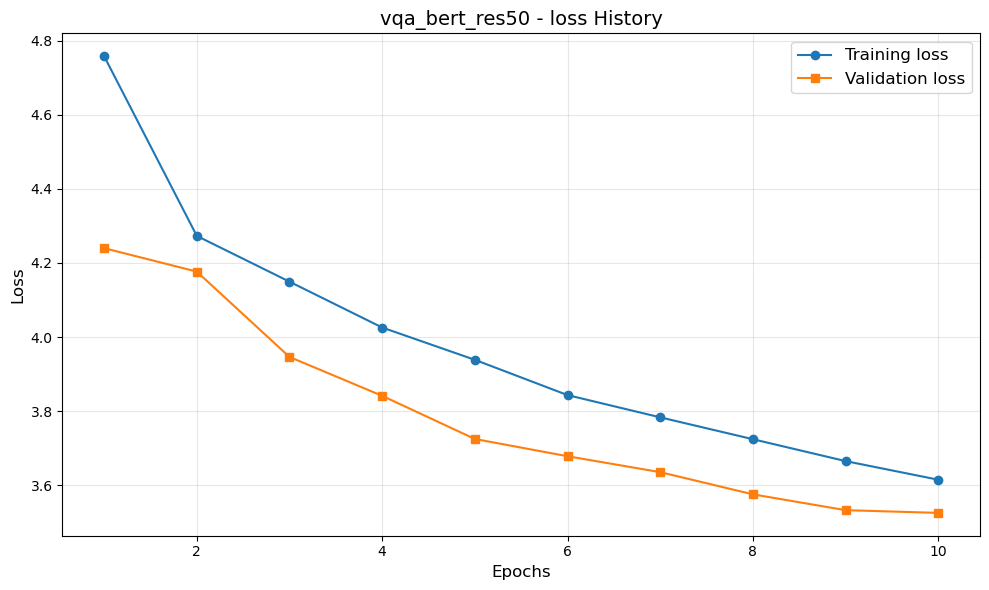

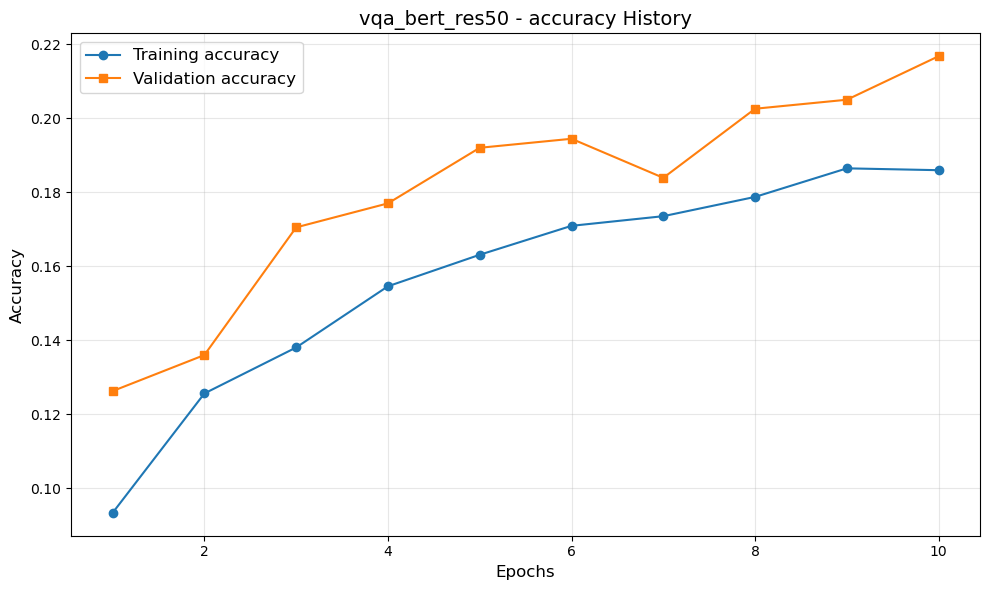

Training model: vqa_bert_cnn
Parameters for vqa_bert_cnn: lr=0.003, weight_decay=0.0001
Epoch 1/10 Model vqa_bert_cnn


Epoch [Train]: 100%|██████████| 312/312 [01:21<00:00,  3.85it/s, accuracy=0.0484, loss=4.5] 


Train Loss: 6.7157, Train Accuracy: 0.0484


Epoch [Val]: 100%|██████████| 77/77 [01:03<00:00,  1.22it/s]


Val Loss: 4.9511, Val Accuracy: 0.0950
Epoch 2/10 Model vqa_bert_cnn


Epoch [Train]: 100%|██████████| 312/312 [01:20<00:00,  3.87it/s, accuracy=0.0706, loss=5.45]


Train Loss: 5.0502, Train Accuracy: 0.0706


Epoch [Val]: 100%|██████████| 77/77 [01:02<00:00,  1.23it/s]


Val Loss: 4.5828, Val Accuracy: 0.0926
Epoch 3/10 Model vqa_bert_cnn


Epoch [Train]: 100%|██████████| 312/312 [01:21<00:00,  3.85it/s, accuracy=0.0701, loss=4.84]


Train Loss: 5.0102, Train Accuracy: 0.0701


Epoch [Val]: 100%|██████████| 77/77 [01:03<00:00,  1.22it/s]


Val Loss: 4.5636, Val Accuracy: 0.0861
Epoch 4/10 Model vqa_bert_cnn


Epoch [Train]: 100%|██████████| 312/312 [01:20<00:00,  3.87it/s, accuracy=0.0777, loss=5.38]


Train Loss: 4.8940, Train Accuracy: 0.0777


Epoch [Val]: 100%|██████████| 77/77 [01:02<00:00,  1.23it/s]


Val Loss: 4.6284, Val Accuracy: 0.0995
Epoch 5/10 Model vqa_bert_cnn


Epoch [Train]: 100%|██████████| 312/312 [01:20<00:00,  3.86it/s, accuracy=0.0798, loss=4.66]


Train Loss: 4.8009, Train Accuracy: 0.0798


Epoch [Val]: 100%|██████████| 77/77 [01:03<00:00,  1.22it/s]


Val Loss: 4.4838, Val Accuracy: 0.0995
Epoch 6/10 Model vqa_bert_cnn


Epoch [Train]: 100%|██████████| 312/312 [01:20<00:00,  3.86it/s, accuracy=0.0827, loss=3.92]


Train Loss: 4.6630, Train Accuracy: 0.0827


Epoch [Val]: 100%|██████████| 77/77 [01:03<00:00,  1.22it/s]


Val Loss: 4.4107, Val Accuracy: 0.0857
Epoch 7/10 Model vqa_bert_cnn


Epoch [Train]: 100%|██████████| 312/312 [01:20<00:00,  3.87it/s, accuracy=0.0833, loss=5.31]


Train Loss: 4.6011, Train Accuracy: 0.0833


Epoch [Val]: 100%|██████████| 77/77 [01:02<00:00,  1.23it/s]


Val Loss: 4.3775, Val Accuracy: 0.0832
Epoch 8/10 Model vqa_bert_cnn


Epoch [Train]: 100%|██████████| 312/312 [01:20<00:00,  3.85it/s, accuracy=0.0805, loss=4.83]


Train Loss: 4.5874, Train Accuracy: 0.0805


Epoch [Val]: 100%|██████████| 77/77 [01:02<00:00,  1.23it/s]


Val Loss: 4.3642, Val Accuracy: 0.0978
Epoch 9/10 Model vqa_bert_cnn


Epoch [Train]: 100%|██████████| 312/312 [01:20<00:00,  3.87it/s, accuracy=0.0822, loss=4.51]


Train Loss: 4.6042, Train Accuracy: 0.0822


Epoch [Val]: 100%|██████████| 77/77 [01:02<00:00,  1.23it/s]


Val Loss: 4.3685, Val Accuracy: 0.0857
Epoch 10/10 Model vqa_bert_cnn


Epoch [Train]: 100%|██████████| 312/312 [01:20<00:00,  3.87it/s, accuracy=0.0818, loss=3.9] 


Train Loss: 4.5738, Train Accuracy: 0.0818


Epoch [Val]: 100%|██████████| 77/77 [01:02<00:00,  1.23it/s]


Val Loss: 4.4317, Val Accuracy: 0.0922


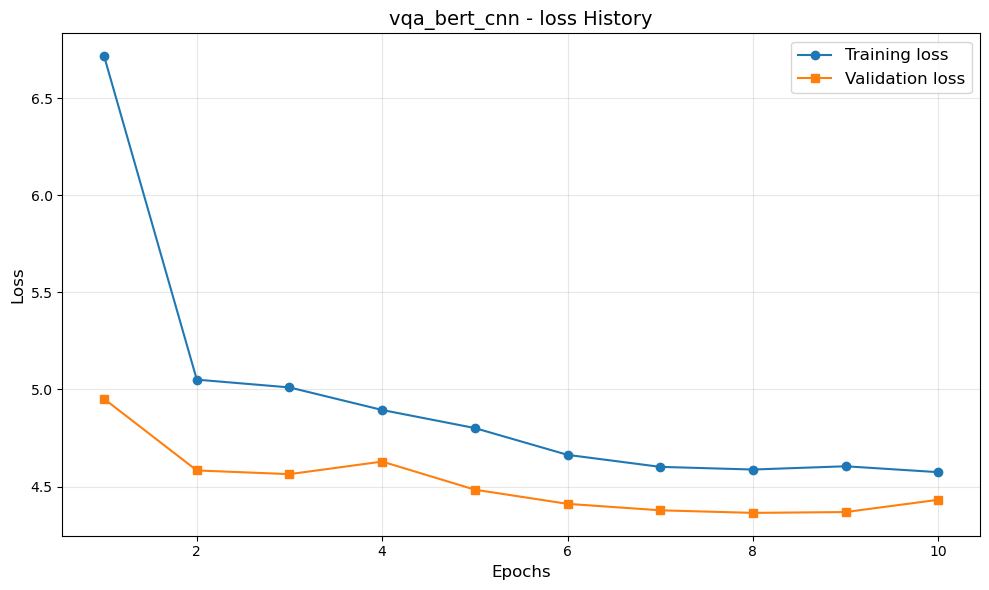

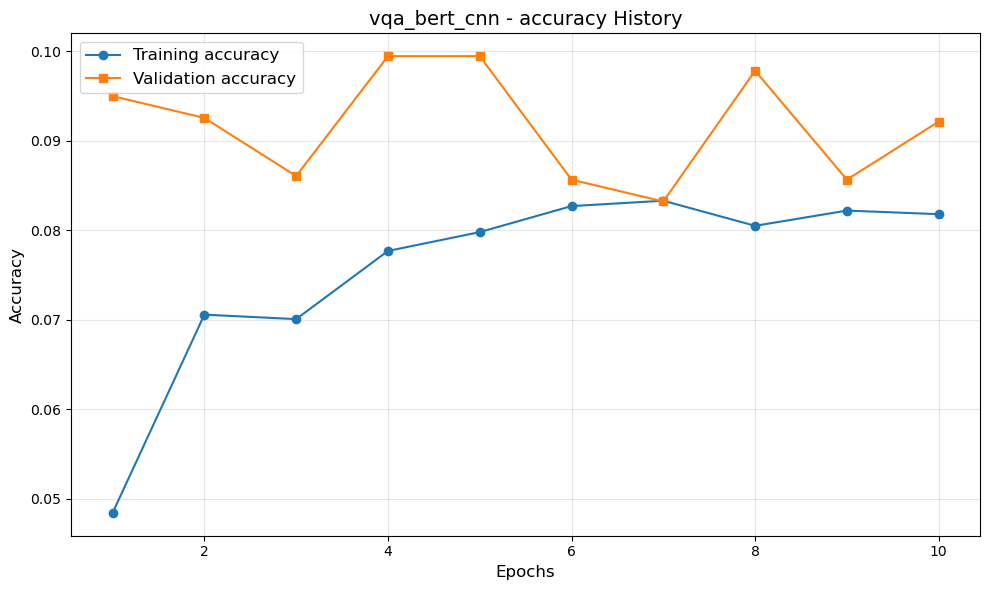

Training model: vqa_bert_vit
Parameters for vqa_bert_vit: lr=0.0003, weight_decay=5e-05
Epoch 1/10 Model vqa_bert_vit


Epoch [Train]: 100%|██████████| 312/312 [01:31<00:00,  3.41it/s, accuracy=0.095, loss=3.52] 


Train Loss: 4.7077, Train Accuracy: 0.0950


Epoch [Val]: 100%|██████████| 77/77 [01:23<00:00,  1.08s/it]


Val Loss: 4.0470, Val Accuracy: 0.1705
Epoch 2/10 Model vqa_bert_vit


Epoch [Train]: 100%|██████████| 312/312 [01:31<00:00,  3.40it/s, accuracy=0.158, loss=4.23]


Train Loss: 4.0080, Train Accuracy: 0.1576


Epoch [Val]: 100%|██████████| 77/77 [01:23<00:00,  1.08s/it]


Val Loss: 3.8115, Val Accuracy: 0.1851
Epoch 3/10 Model vqa_bert_vit


Epoch [Train]: 100%|██████████| 312/312 [01:31<00:00,  3.40it/s, accuracy=0.181, loss=4.08]


Train Loss: 3.7534, Train Accuracy: 0.1810


Epoch [Val]: 100%|██████████| 77/77 [01:23<00:00,  1.08s/it]


Val Loss: 3.6333, Val Accuracy: 0.1941
Epoch 4/10 Model vqa_bert_vit


Epoch [Train]: 100%|██████████| 312/312 [01:31<00:00,  3.40it/s, accuracy=0.203, loss=3.06]


Train Loss: 3.5813, Train Accuracy: 0.2030


Epoch [Val]: 100%|██████████| 77/77 [01:23<00:00,  1.08s/it]


Val Loss: 3.5136, Val Accuracy: 0.2188
Epoch 5/10 Model vqa_bert_vit


Epoch [Train]: 100%|██████████| 312/312 [01:31<00:00,  3.40it/s, accuracy=0.222, loss=2.94]


Train Loss: 3.4256, Train Accuracy: 0.2218


Epoch [Val]: 100%|██████████| 77/77 [01:23<00:00,  1.08s/it]


Val Loss: 3.5031, Val Accuracy: 0.2180
Epoch 6/10 Model vqa_bert_vit


Epoch [Train]: 100%|██████████| 312/312 [01:31<00:00,  3.40it/s, accuracy=0.231, loss=3.72]


Train Loss: 3.3092, Train Accuracy: 0.2311


Epoch [Val]: 100%|██████████| 77/77 [01:23<00:00,  1.08s/it]


Val Loss: 3.3662, Val Accuracy: 0.2339
Epoch 7/10 Model vqa_bert_vit


Epoch [Train]: 100%|██████████| 312/312 [01:31<00:00,  3.40it/s, accuracy=0.241, loss=3.97]


Train Loss: 3.1635, Train Accuracy: 0.2411


Epoch [Val]: 100%|██████████| 77/77 [01:23<00:00,  1.08s/it]


Val Loss: 3.3229, Val Accuracy: 0.2473
Epoch 8/10 Model vqa_bert_vit


Epoch [Train]: 100%|██████████| 312/312 [01:32<00:00,  3.39it/s, accuracy=0.262, loss=2.9] 


Train Loss: 3.0480, Train Accuracy: 0.2619


Epoch [Val]: 100%|██████████| 77/77 [01:23<00:00,  1.08s/it]


Val Loss: 3.3093, Val Accuracy: 0.2525
Epoch 9/10 Model vqa_bert_vit


Epoch [Train]: 100%|██████████| 312/312 [01:31<00:00,  3.40it/s, accuracy=0.276, loss=2.73]


Train Loss: 2.9458, Train Accuracy: 0.2764


Epoch [Val]: 100%|██████████| 77/77 [01:23<00:00,  1.08s/it]


Val Loss: 3.2786, Val Accuracy: 0.2611
Epoch 10/10 Model vqa_bert_vit


Epoch [Train]: 100%|██████████| 312/312 [01:31<00:00,  3.39it/s, accuracy=0.29, loss=2.29] 


Train Loss: 2.8430, Train Accuracy: 0.2903


Epoch [Val]: 100%|██████████| 77/77 [01:23<00:00,  1.08s/it]


Val Loss: 3.2661, Val Accuracy: 0.2582


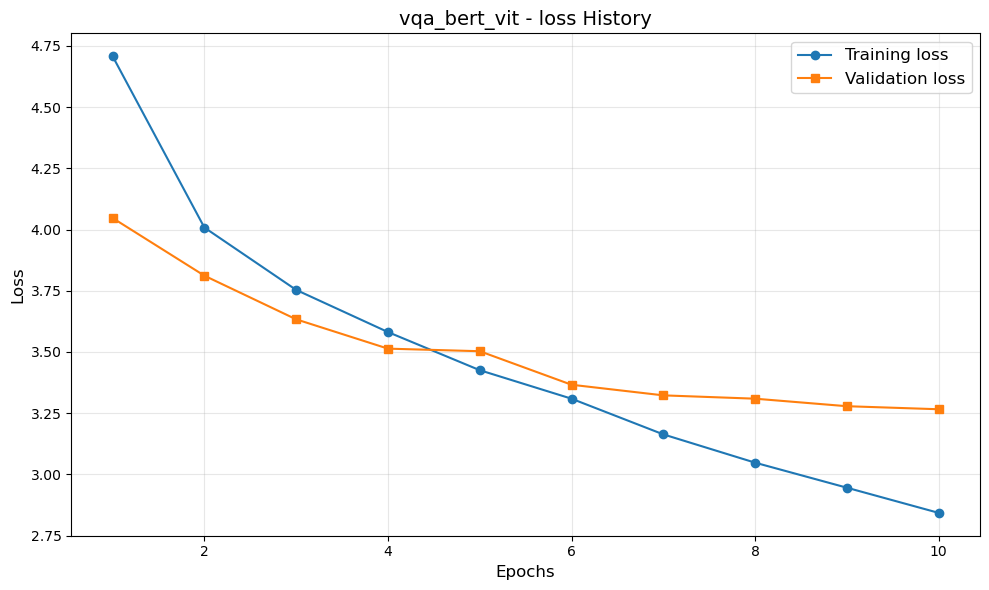

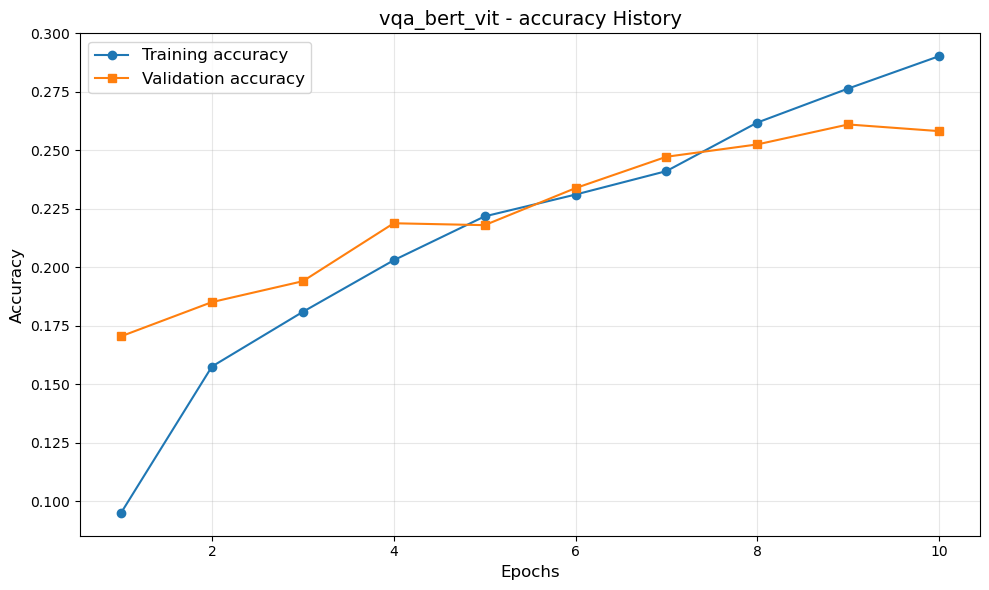

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:879: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Training model: vqa_lstm_res50
Parameters for vqa_lstm_res50: lr=0.003, weight_decay=0.0001
Epoch 1/10 Model vqa_lstm_res50


Epoch [Train]: 100%|██████████| 312/312 [01:01<00:00,  5.08it/s, accuracy=0.035, loss=5.51] 


Train Loss: 5.8666, Train Accuracy: 0.0350


Epoch [Val]: 100%|██████████| 77/77 [00:10<00:00,  7.34it/s]


Val Loss: 5.2829, Val Accuracy: 0.0406
Epoch 2/10 Model vqa_lstm_res50


Epoch [Train]: 100%|██████████| 312/312 [01:01<00:00,  5.07it/s, accuracy=0.034, loss=5.76] 


Train Loss: 9.0670, Train Accuracy: 0.0340


Epoch [Val]: 100%|██████████| 77/77 [00:10<00:00,  7.18it/s]


Val Loss: 5.8011, Val Accuracy: 0.0455
Epoch 3/10 Model vqa_lstm_res50


Epoch [Train]: 100%|██████████| 312/312 [01:01<00:00,  5.09it/s, accuracy=0.0433, loss=5.53]


Train Loss: 9.1384, Train Accuracy: 0.0433


Epoch [Val]: 100%|██████████| 77/77 [00:10<00:00,  7.36it/s]


Val Loss: 5.4352, Val Accuracy: 0.0455
Epoch 4/10 Model vqa_lstm_res50


Epoch [Train]: 100%|██████████| 312/312 [01:01<00:00,  5.08it/s, accuracy=0.0442, loss=5.36]


Train Loss: 5.3718, Train Accuracy: 0.0442


Epoch [Val]: 100%|██████████| 77/77 [00:10<00:00,  7.35it/s]


Val Loss: 5.2179, Val Accuracy: 0.0455
Epoch 5/10 Model vqa_lstm_res50


Epoch [Train]: 100%|██████████| 312/312 [01:01<00:00,  5.07it/s, accuracy=0.0443, loss=4.98]


Train Loss: 5.1729, Train Accuracy: 0.0443


Epoch [Val]: 100%|██████████| 77/77 [00:10<00:00,  7.19it/s]


Val Loss: 5.0989, Val Accuracy: 0.0455
Epoch 6/10 Model vqa_lstm_res50


Epoch [Train]: 100%|██████████| 312/312 [01:01<00:00,  5.10it/s, accuracy=0.0443, loss=4.76]


Train Loss: 5.0838, Train Accuracy: 0.0443


Epoch [Val]: 100%|██████████| 77/77 [00:10<00:00,  7.33it/s]


Val Loss: 5.0366, Val Accuracy: 0.0455
Epoch 7/10 Model vqa_lstm_res50


Epoch [Train]: 100%|██████████| 312/312 [01:01<00:00,  5.08it/s, accuracy=0.0443, loss=5.33]


Train Loss: 5.0387, Train Accuracy: 0.0443


Epoch [Val]: 100%|██████████| 77/77 [00:10<00:00,  7.22it/s]


Val Loss: 5.0032, Val Accuracy: 0.0455
Epoch 8/10 Model vqa_lstm_res50


Epoch [Train]: 100%|██████████| 312/312 [01:01<00:00,  5.07it/s, accuracy=0.0443, loss=4.96]


Train Loss: 5.0143, Train Accuracy: 0.0443


Epoch [Val]: 100%|██████████| 77/77 [00:10<00:00,  7.33it/s]


Val Loss: 4.9850, Val Accuracy: 0.0455
Epoch 9/10 Model vqa_lstm_res50


Epoch [Train]: 100%|██████████| 312/312 [01:01<00:00,  5.06it/s, accuracy=0.0443, loss=5.45]


Train Loss: 5.0004, Train Accuracy: 0.0443


Epoch [Val]: 100%|██████████| 77/77 [00:10<00:00,  7.12it/s]


Val Loss: 4.9740, Val Accuracy: 0.0455
Epoch 10/10 Model vqa_lstm_res50


Epoch [Train]: 100%|██████████| 312/312 [01:01<00:00,  5.07it/s, accuracy=0.0443, loss=4.93]


Train Loss: 4.9917, Train Accuracy: 0.0443


Epoch [Val]: 100%|██████████| 77/77 [00:10<00:00,  7.20it/s]


Val Loss: 4.9669, Val Accuracy: 0.0455


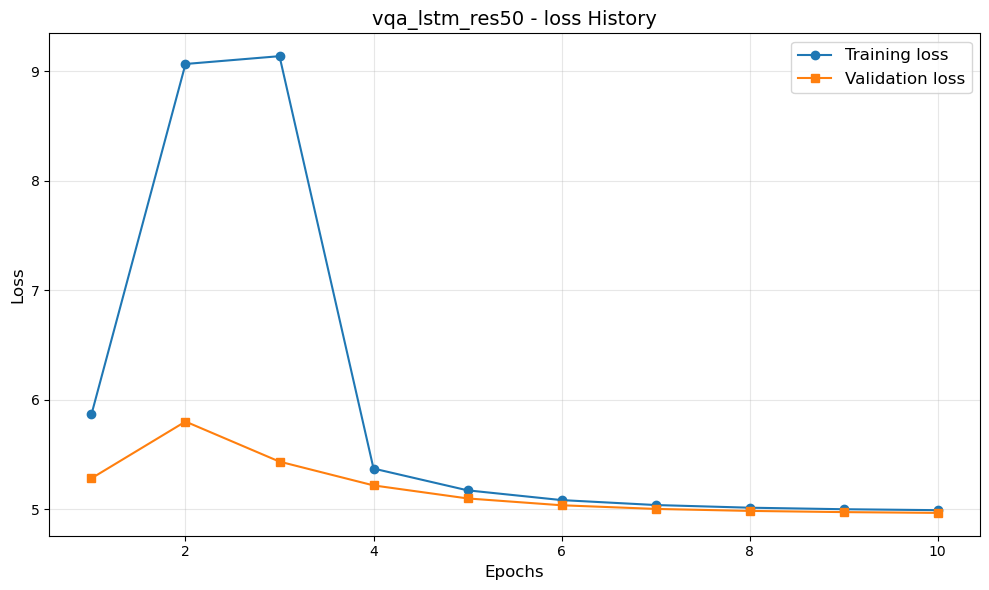

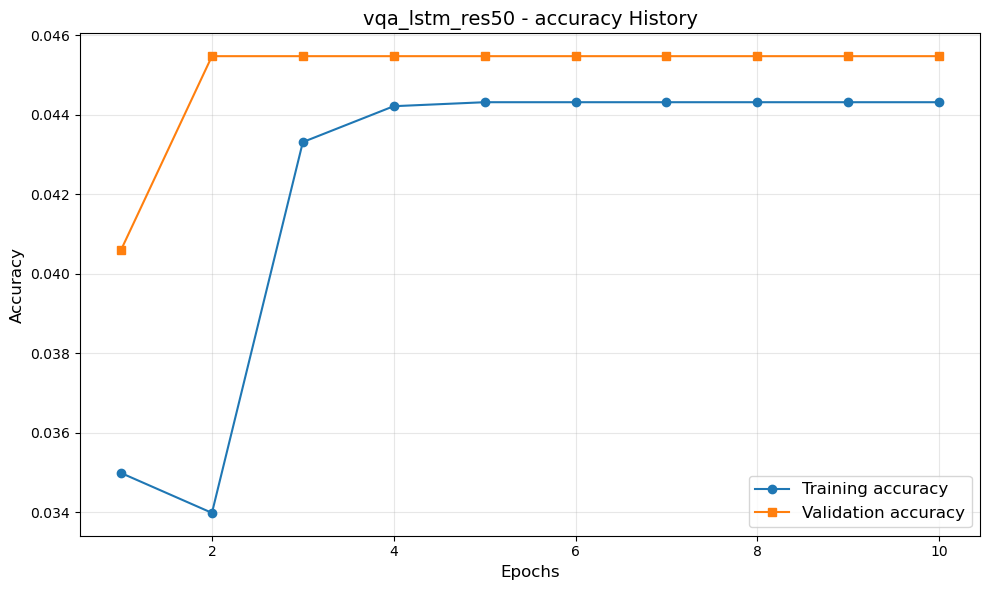

Training model: vqa_lstm_cnn
Parameters for vqa_lstm_cnn: lr=0.003, weight_decay=0.0001
Epoch 1/10 Model vqa_lstm_cnn


Epoch [Train]: 100%|██████████| 312/312 [00:43<00:00,  7.21it/s, accuracy=0.0213, loss=6]   


Train Loss: 7.4186, Train Accuracy: 0.0213


Epoch [Val]: 100%|██████████| 77/77 [00:10<00:00,  7.44it/s]


Val Loss: 6.0260, Val Accuracy: 0.0455
Epoch 2/10 Model vqa_lstm_cnn


Epoch [Train]: 100%|██████████| 312/312 [00:42<00:00,  7.37it/s, accuracy=0.0431, loss=5.62]


Train Loss: 5.7876, Train Accuracy: 0.0431


Epoch [Val]: 100%|██████████| 77/77 [00:10<00:00,  7.05it/s]


Val Loss: 5.5738, Val Accuracy: 0.0455
Epoch 3/10 Model vqa_lstm_cnn


Epoch [Train]: 100%|██████████| 312/312 [00:43<00:00,  7.18it/s, accuracy=0.0443, loss=5.23]


Train Loss: 5.4326, Train Accuracy: 0.0443


Epoch [Val]: 100%|██████████| 77/77 [00:10<00:00,  7.10it/s]


Val Loss: 5.3005, Val Accuracy: 0.0455
Epoch 4/10 Model vqa_lstm_cnn


Epoch [Train]: 100%|██████████| 312/312 [00:42<00:00,  7.29it/s, accuracy=0.0443, loss=5.28]


Train Loss: 5.2252, Train Accuracy: 0.0443


Epoch [Val]: 100%|██████████| 77/77 [00:10<00:00,  7.57it/s]


Val Loss: 5.1448, Val Accuracy: 0.0455
Epoch 5/10 Model vqa_lstm_cnn


Epoch [Train]: 100%|██████████| 312/312 [00:42<00:00,  7.29it/s, accuracy=0.0427, loss=5.06]


Train Loss: 11.8698, Train Accuracy: 0.0427


Epoch [Val]: 100%|██████████| 77/77 [00:10<00:00,  7.18it/s]


Val Loss: 5.0697, Val Accuracy: 0.0455
Epoch 6/10 Model vqa_lstm_cnn


Epoch [Train]: 100%|██████████| 312/312 [00:43<00:00,  7.21it/s, accuracy=0.0443, loss=5.15]


Train Loss: 5.0595, Train Accuracy: 0.0443


Epoch [Val]: 100%|██████████| 77/77 [00:10<00:00,  7.16it/s]


Val Loss: 5.0228, Val Accuracy: 0.0455
Epoch 7/10 Model vqa_lstm_cnn


Epoch [Train]: 100%|██████████| 312/312 [00:43<00:00,  7.18it/s, accuracy=0.0443, loss=5.39]


Train Loss: 5.0253, Train Accuracy: 0.0443


Epoch [Val]: 100%|██████████| 77/77 [00:10<00:00,  7.48it/s]


Val Loss: 4.9964, Val Accuracy: 0.0455
Epoch 8/10 Model vqa_lstm_cnn


Epoch [Train]: 100%|██████████| 312/312 [00:42<00:00,  7.41it/s, accuracy=0.0438, loss=4.88]


Train Loss: 5.1967, Train Accuracy: 0.0438


Epoch [Val]: 100%|██████████| 77/77 [00:10<00:00,  7.57it/s]


Val Loss: 4.9816, Val Accuracy: 0.0455
Epoch 9/10 Model vqa_lstm_cnn


Epoch [Train]: 100%|██████████| 312/312 [00:42<00:00,  7.37it/s, accuracy=0.0442, loss=5.08]


Train Loss: 5.3061, Train Accuracy: 0.0442


Epoch [Val]: 100%|██████████| 77/77 [00:10<00:00,  7.60it/s]


Val Loss: 4.9718, Val Accuracy: 0.0455
Epoch 10/10 Model vqa_lstm_cnn


Epoch [Train]: 100%|██████████| 312/312 [00:43<00:00,  7.19it/s, accuracy=0.0443, loss=5.01]


Train Loss: 4.9907, Train Accuracy: 0.0443


Epoch [Val]: 100%|██████████| 77/77 [00:10<00:00,  7.17it/s]


Val Loss: 4.9655, Val Accuracy: 0.0455


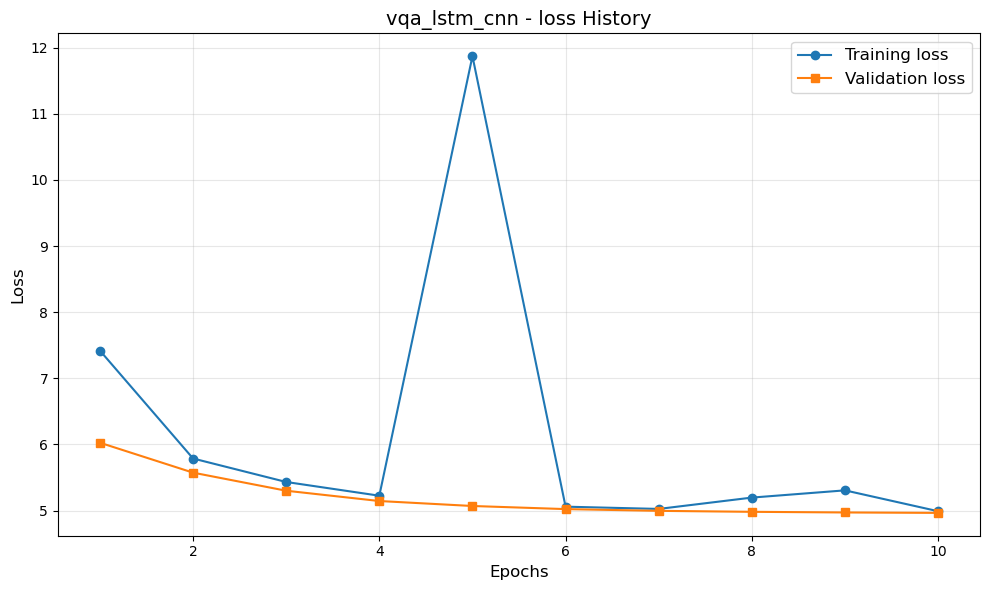

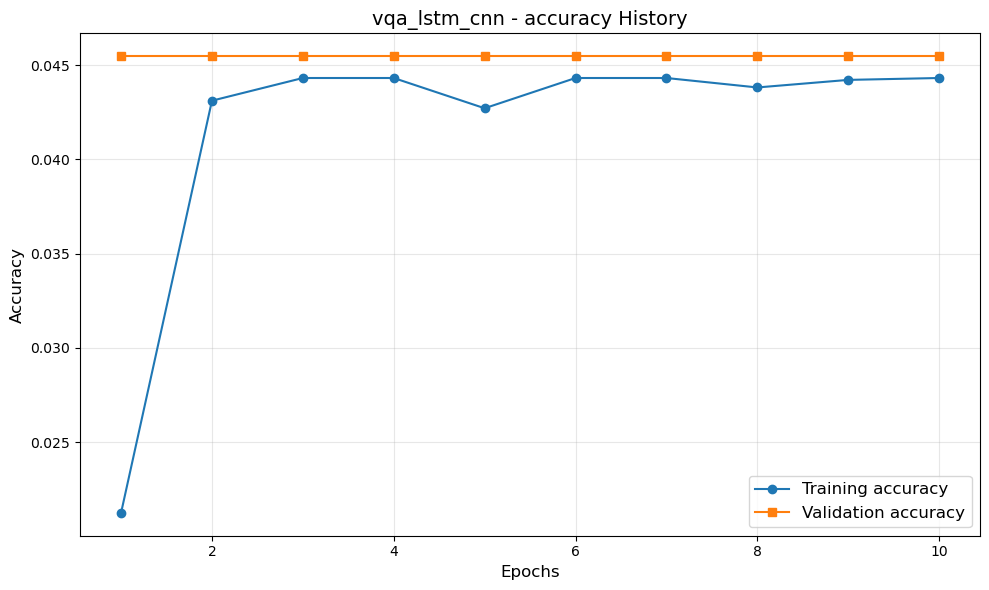

Training model: vqa_lstm_vit
Parameters for vqa_lstm_vit: lr=0.0005, weight_decay=0.0001
Epoch 1/10 Model vqa_lstm_vit


Epoch [Train]: 100%|██████████| 312/312 [00:47<00:00,  6.51it/s, accuracy=0.0423, loss=4.1] 


Train Loss: 5.1428, Train Accuracy: 0.0423


Epoch [Val]: 100%|██████████| 77/77 [00:26<00:00,  2.87it/s]


Val Loss: 4.7322, Val Accuracy: 0.0585
Epoch 2/10 Model vqa_lstm_vit


Epoch [Train]: 100%|██████████| 312/312 [00:47<00:00,  6.56it/s, accuracy=0.059, loss=4.11] 


Train Loss: 4.7353, Train Accuracy: 0.0590


Epoch [Val]: 100%|██████████| 77/77 [00:26<00:00,  2.87it/s]


Val Loss: 4.5947, Val Accuracy: 0.0666
Epoch 3/10 Model vqa_lstm_vit


Epoch [Train]: 100%|██████████| 312/312 [00:47<00:00,  6.51it/s, accuracy=0.0667, loss=4.43]


Train Loss: 4.5897, Train Accuracy: 0.0667


Epoch [Val]: 100%|██████████| 77/77 [00:26<00:00,  2.88it/s]


Val Loss: 4.5546, Val Accuracy: 0.0662
Epoch 4/10 Model vqa_lstm_vit


Epoch [Train]: 100%|██████████| 312/312 [00:47<00:00,  6.51it/s, accuracy=0.0755, loss=4.81]


Train Loss: 4.4799, Train Accuracy: 0.0755


Epoch [Val]: 100%|██████████| 77/77 [00:26<00:00,  2.89it/s]


Val Loss: 4.4999, Val Accuracy: 0.0751
Epoch 5/10 Model vqa_lstm_vit


Epoch [Train]: 100%|██████████| 312/312 [00:47<00:00,  6.58it/s, accuracy=0.081, loss=4.43] 


Train Loss: 4.3940, Train Accuracy: 0.0810


Epoch [Val]: 100%|██████████| 77/77 [00:26<00:00,  2.87it/s]


Val Loss: 4.4752, Val Accuracy: 0.0804
Epoch 6/10 Model vqa_lstm_vit


Epoch [Train]: 100%|██████████| 312/312 [00:48<00:00,  6.47it/s, accuracy=0.0823, loss=4.24]


Train Loss: 4.3201, Train Accuracy: 0.0823


Epoch [Val]: 100%|██████████| 77/77 [00:26<00:00,  2.90it/s]


Val Loss: 4.4595, Val Accuracy: 0.0711
Epoch 7/10 Model vqa_lstm_vit


Epoch [Train]: 100%|██████████| 312/312 [00:47<00:00,  6.52it/s, accuracy=0.0899, loss=4.11]


Train Loss: 4.2232, Train Accuracy: 0.0899


Epoch [Val]: 100%|██████████| 77/77 [00:26<00:00,  2.87it/s]


Val Loss: 4.4456, Val Accuracy: 0.0731
Epoch 8/10 Model vqa_lstm_vit


Epoch [Train]: 100%|██████████| 312/312 [00:48<00:00,  6.50it/s, accuracy=0.0905, loss=3.87]


Train Loss: 4.1539, Train Accuracy: 0.0905


Epoch [Val]: 100%|██████████| 77/77 [00:26<00:00,  2.86it/s]


Val Loss: 4.4258, Val Accuracy: 0.0731
Epoch 9/10 Model vqa_lstm_vit


Epoch [Train]: 100%|██████████| 312/312 [00:47<00:00,  6.51it/s, accuracy=0.0942, loss=3.51]


Train Loss: 4.0758, Train Accuracy: 0.0942


Epoch [Val]: 100%|██████████| 77/77 [00:26<00:00,  2.89it/s]


Val Loss: 4.4268, Val Accuracy: 0.0828
Epoch 10/10 Model vqa_lstm_vit


Epoch [Train]: 100%|██████████| 312/312 [00:47<00:00,  6.56it/s, accuracy=0.0978, loss=3.93]


Train Loss: 4.0082, Train Accuracy: 0.0978


Epoch [Val]: 100%|██████████| 77/77 [00:26<00:00,  2.89it/s]


Val Loss: 4.4419, Val Accuracy: 0.0775


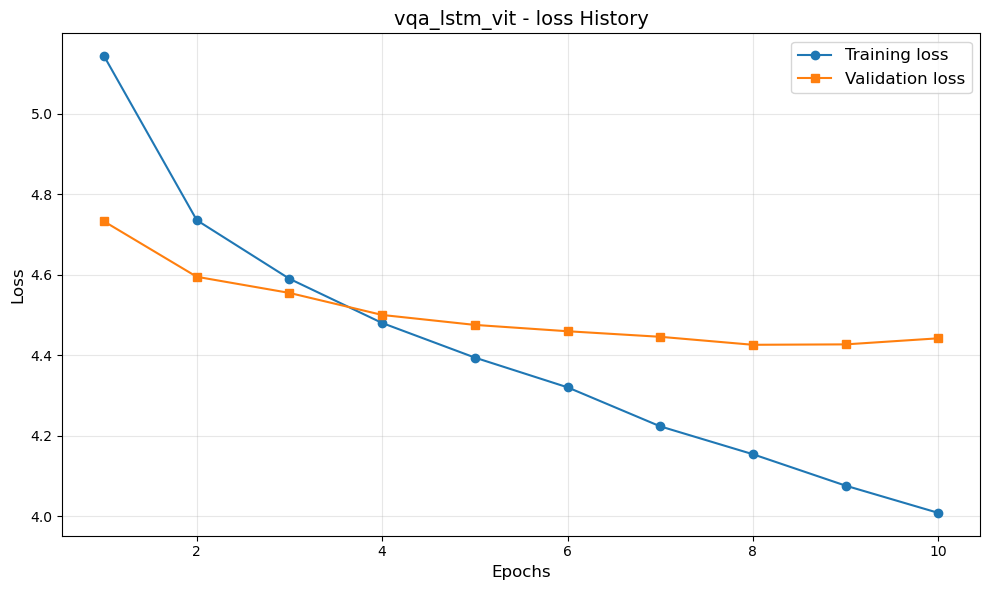

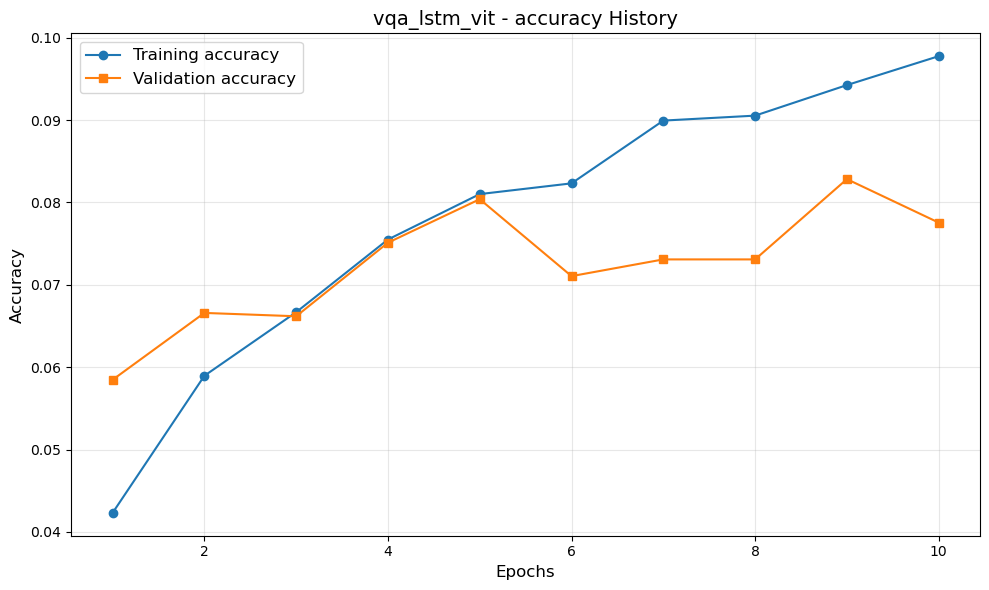

Total training time: 6906.4 sec


In [ ]:
import gc
import copy
from torch.cuda.amp import autocast, GradScaler
import time
gc.collect()
torch.cuda.empty_cache()

history = dict()

s = time.time()
history = dict()
for id_text, text_encoder in text_encoders:
    for id_img, img_encoder in img_encoders:
        model_name = f'vqa_{id_text}_{id_img}'
        print(f"Training model: {model_name}")
        
        hyperparams = custom_hyperparams[f'{id_text}_{id_img}']
        lr = hyperparams['lr']
        weight_decay = hyperparams['weight_decay']
        print(f"Parameters for {model_name}: lr={lr}, weight_decay={weight_decay}")
        
        history[model_name] = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
        img_encoder = copy.deepcopy(img_encoder.to(device))
        text_encoder = copy.deepcopy(text_encoder.to(device))
        model = VQA_model(n_classes, img_encoder, text_encoder, device, hidden_size, dropout_prob=dropout_prob).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        scaler = GradScaler()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs} Model {model_name}')
            epoch_loss, epoch_accuracy = train_vqa_model(model, train_loader, criterion, optimizer, scaler, device)
            val_epoch_loss, val_epoch_accuracy = validate(model, val_loader, criterion, optimizer, device)
            history[model_name]['loss'].append(epoch_loss)
            history[model_name]['accuracy'].append(epoch_accuracy)
            history[model_name]['val_loss'].append(val_epoch_loss)
            history[model_name]['val_accuracy'].append(val_epoch_accuracy)
        
        torch.save(model.state_dict(), f'{model_name}.pt')
        plot_metric_history(history[model_name], model_name, 'loss')
        plot_metric_history(history[model_name], model_name, 'accuracy')
        
        img_encoder.cpu()
        text_encoder.cpu()
        model.cpu()
        gc.collect()
        torch.cuda.empty_cache()

e = time.time()
print(f"Total training time: {e-s:.1f} sec")

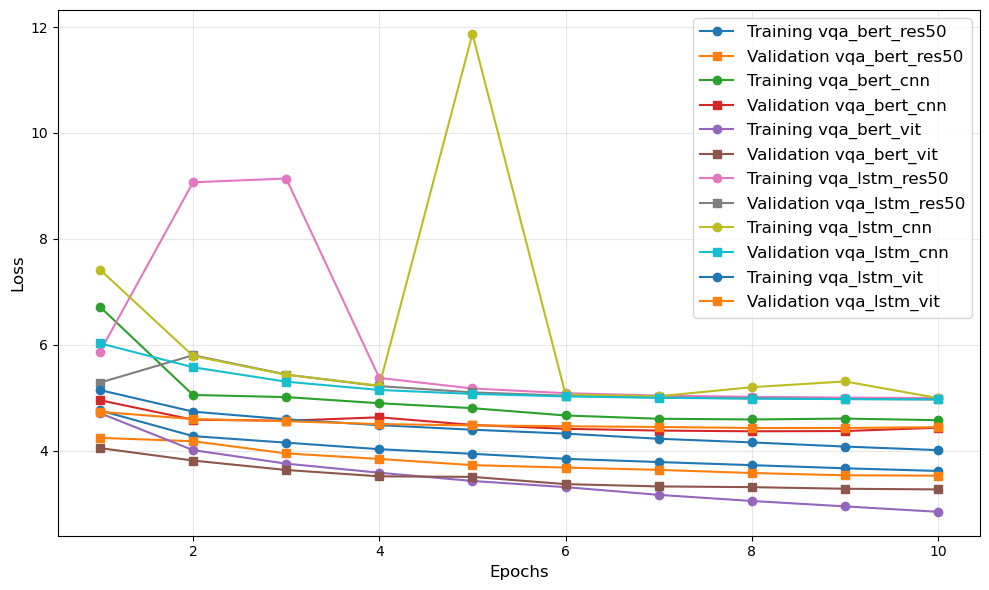

In [62]:
metric = 'loss'
plt.figure(figsize=(10, 6))
for name,hist in history.items():
    train_metric = hist.get(metric)
    val_metric = hist.get(f'val_{metric}')
    epochs = range(1, len(train_metric) + 1)
    plt.plot(epochs, train_metric, label=f'Training {name}', marker='o')
    plt.plot(epochs, val_metric, label=f'Validation {name}', marker='s')
plt.xlabel("Epochs", fontsize=12)
plt.ylabel(metric.capitalize(), fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

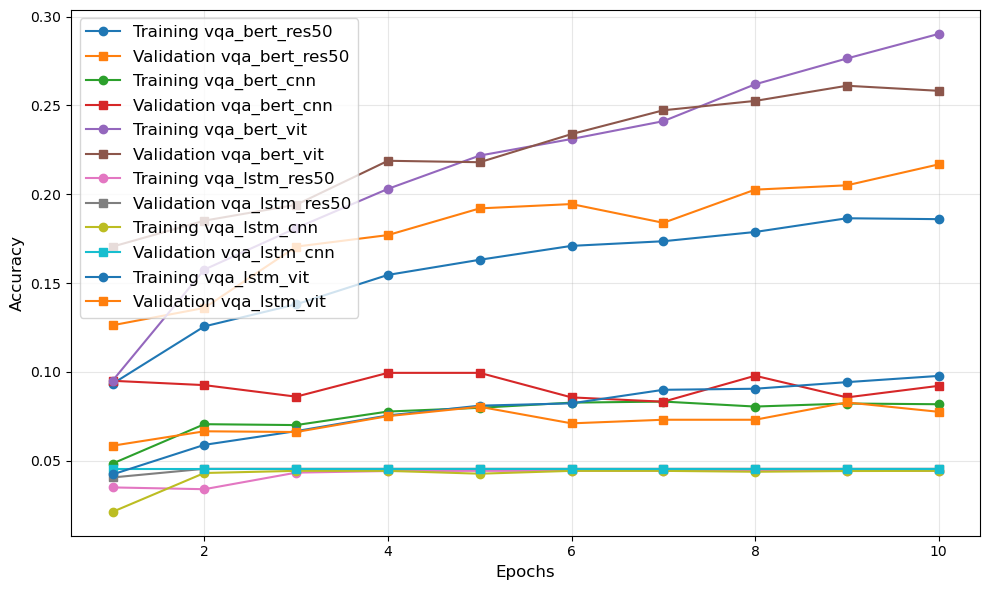

In [63]:
metric = 'accuracy'
plt.figure(figsize=(10, 6))
for name,hist in history.items():
    train_metric = hist.get(metric)
    val_metric = hist.get(f'val_{metric}')
    epochs = range(1, len(train_metric) + 1)
    plt.plot(epochs, train_metric, label=f'Training {name}', marker='o')
    plt.plot(epochs, val_metric, label=f'Validation {name}', marker='s')
plt.xlabel("Epochs", fontsize=12)
plt.ylabel(metric.capitalize(), fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()